# Data Report 

## Question
**How has the extent of sea ice changed over time in relation to global temperature changes?**

## Data Sources
1. **Global Temperature Change Data**
   - **Source**: "Environment_Temperature_change_E_All_Data_NOFLAG.csv"
   - **Content**: This dataset contains global temperature changes over time.
   - **Structure and Quality**: The dataset includes columns such as `Year`, `Country`, and temperature anomalies. It is structured in a tabular format and includes yearly data from various countries.
   - **License**: Open Data License - This data is under an open data license which allows for free use with proper attribution.

2. **Sea Ice Extent Data**
   - **Source**: "seaice.csv"
   - **Content**: This dataset contains data on the extent of sea ice over time.
   - **Structure and Quality**: The dataset includes columns such as `Year`, `Month`, `Day`, and `Extent`. It is also structured in a tabular format with monthly data.
   - **License**: Open Data License - This data is also under an open data license which allows for free use with proper attribution.

## Data Pipeline
### Overview
The data pipeline gathers, purges, transforms, and analyzes data in order to provide insights into the relationship between variations in sea ice extent and global temperature.

### Steps
1. **Data Collection**: Load the datasets from the provided sources using a custom pipeline script.
2. **Data Cleaning**: Handle missing values, standardize date formats, and ensure data consistency.
3. **Data Transformation**: Aggregate data to match temporal granularity as yearly averages, normalize values, and merge datasets for combined analysis.
4. **Data Analysis**: Calculate correlations and visualize trends between temperature anomalies and sea ice extent.

### Challenges and Solutions
- **Data Inconsistency**: Resolved by standardizing date formats and ensuring both datasets align temporally.
- **Missing Values**: Handled through interpolation or omission depending on the extent of missing data.
- **Changing Input Data**: Implemented automated checks and alerts for data updates or changes.

## Results and Limitations
### Output Data
- **Structure**: The output data includes aggregated and cleaned data for global temperature anomalies and sea ice extent, ready for analysis.
- **Format**: The output is stored in SQlite format for easy access and compatibility with various analysis tools.

### Reflection
- **Data Quality**: High-quality data has been processed, and it has undergone rigorous cleansing and consistency tests.
- **Potential Issues**: The analysis may be impacted by regional disparities and temporal mismatch. Robust results might require more refinement and cross-validation using multiple data sources.

### Disclaimer
Its original goal was to examine how heart disease and climate change are related. Unfortunately, it was discovered that this decision was poorly thought out because there was insufficient information to analyze and determine a significant association. Since this choice is better supported by the data at hand, it was made to investigate the relationship between sea ice extent and global temperature variations using the existing datasets.


## Conclusion
This data pipeline offers a thorough method for examining the relationship between variations in sea ice extent and changes in global temperature. Reliable and perceptive analysis is made possible by the automated processes that guarantee data consistency and integrity.

# Data Report - Implementation
## Imports 


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from kaggle.api.kaggle_api_extended import KaggleApi

## Data Collection and Preparation from Kaggle
This section details the process of collecting the necessary datasets from Kaggle, preparing them for analysis, and ensuring the data is ready for further processing.

In [ ]:
data_path = './data'
table_names = ['ice', 'temperature']

dataset_1 = "nsidcorg/daily-sea-ice-extent-data"
dataset_2 = "sevgisarac/temperature-change"

api = KaggleApi()
api.authenticate()

for dataset in [dataset_1, dataset_2]:
    api.dataset_download_files(dataset, path=data_path, unzip=True)

csv_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
if len(csv_files) < 2:
    raise ValueError("Not enough CSV files.")

df1 = pd.read_csv(os.path.join(data_path, csv_files[0]), encoding='cp1252')
df2 = pd.read_csv(os.path.join(data_path, csv_files[1]))

temperature_data, seaice_data = df1, df2

## Data Transformation and Cleaning
### Global Temperature Data
Transform the global temperature data to extract relevant information and calculate yearly averages.

In [3]:

global_temp = temperature_data[temperature_data['Area'] == 'World'][['Months', 'Element', 'Unit'] + [col for col in temperature_data.columns if col.startswith('Y')]]

global_temp = global_temp.melt(id_vars=['Months', 'Element', 'Unit'], var_name='Year', value_name='Value')

global_temp['Year'] = global_temp['Year'].str.extract('(\d+)').astype(int)
global_temp_anomalies = global_temp[(global_temp['Element'] == 'Temperature change') & (global_temp['Months'] == 'Meteorological year')]

global_temp_avg = global_temp_anomalies.groupby('Year')['Value'].mean().reset_index()
global_temp_avg.columns = ['Year', 'Temperature_Anomaly']

global_temp_avg.head()


,Year,Temperature_Anomaly
0,1961,0.207
1,1962,0.034
2,1963,0.159
3,1964,-0.253
4,1965,-0.226


### Sea Ice Data
Clean and aggregate the sea ice data to yearly averages.

In [4]:


seaice_data.columns = seaice_data.columns.str.strip()

seaice_data['Date'] = pd.to_datetime(seaice_data[['Year', 'Month', 'Day']])
seaice_data['Year'] = seaice_data['Date'].dt.year

seaice_yearly_avg = seaice_data.groupby('Year')['Extent'].mean().reset_index()
seaice_yearly_avg.columns = ['Year', 'Sea_Ice_Extent']

merged_data = pd.merge(global_temp_avg, seaice_yearly_avg, on='Year', how='inner')

merged_data.head()



,Year,Temperature_Anomaly,Sea_Ice_Extent
0,1978,0.004,12.976838
1,1979,0.225,12.019349
2,1980,0.330,11.785219
3,1981,0.439,11.776148
4,1982,0.078,12.048755


## Calculate the correlation
Determine whether there is a linear relationship between Temperature_Anomaly and Sea_Ice_Extent by doing a correlation calculation. If so, this will help us create a predictive model for longer periods of time in the future.

In [5]:
correlation = merged_data[['Temperature_Anomaly', 'Sea_Ice_Extent']].corr()
correlation

,Temperature_Anomaly,Sea_Ice_Extent
Temperature_Anomaly,1.000000,-0.723884
Sea_Ice_Extent,-0.723884,1.000000


## Overview of the Data with Plots

- Histogram of Temperature Anomalies
- Histogram of Sea Ice Extent
- Scatter Plot of Temperature Anomalies vs. Sea Ice Extent
- Time Series Plot of Temperature Anomalies and Sea Ice Extent

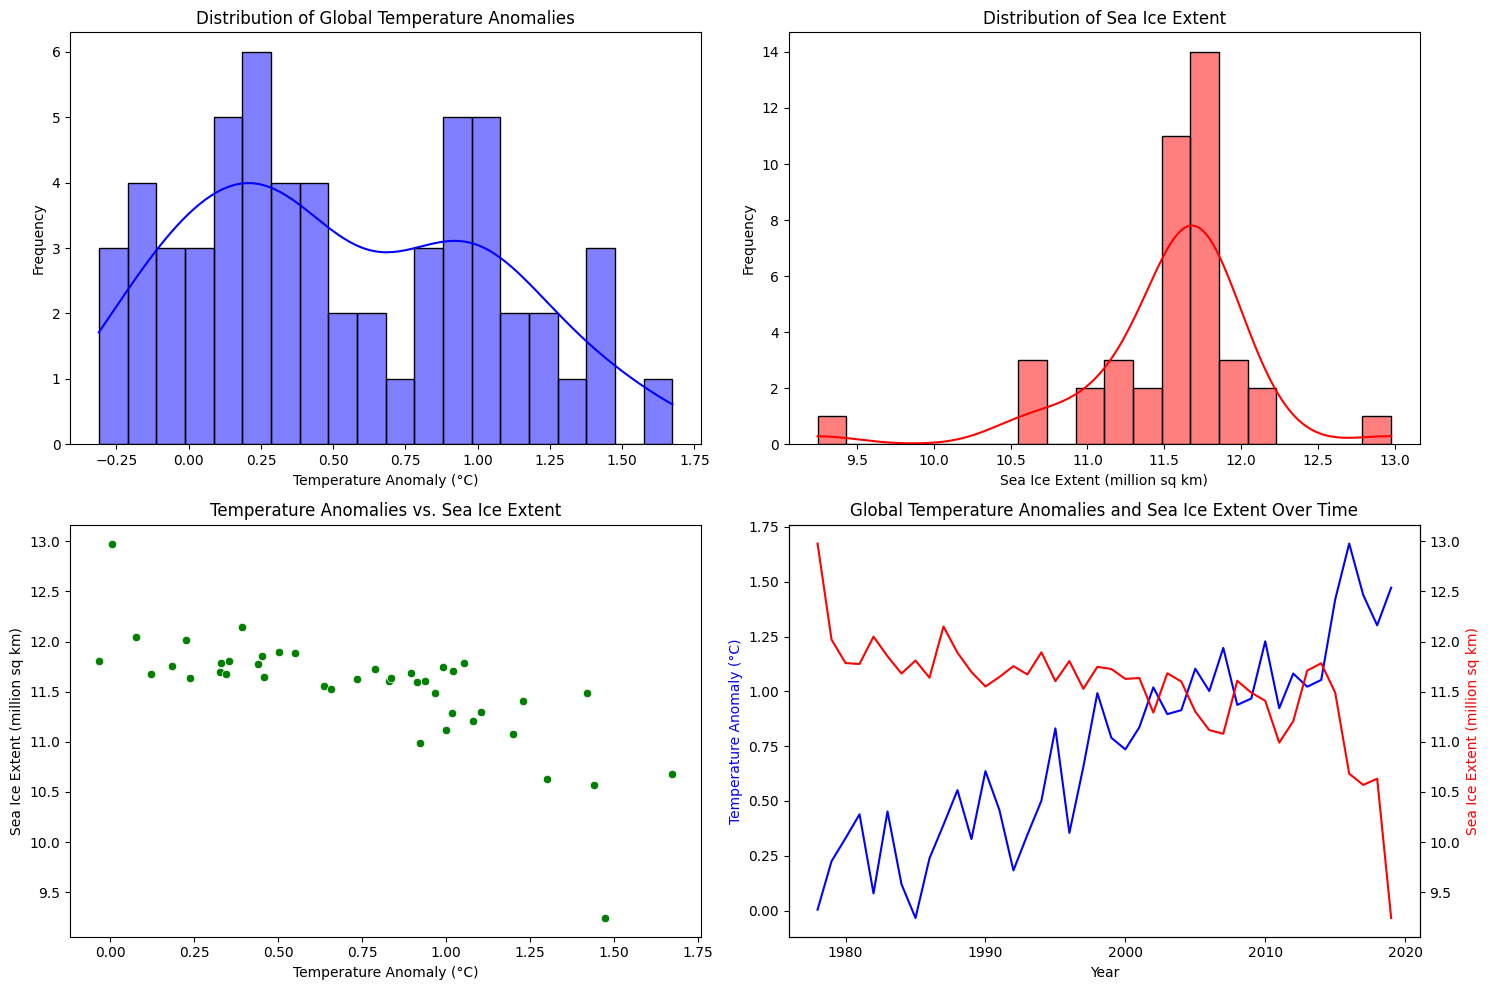

In [6]:
import matplotlib.pyplot as plt



fig, axs = plt.subplots(2, 2, figsize=(15, 10))


sns.histplot(global_temp_avg['Temperature_Anomaly'], bins=20, color='blue', kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Global Temperature Anomalies')
axs[0, 0].set_xlabel('Temperature Anomaly (°C)')
axs[0, 0].set_ylabel('Frequency')


sns.histplot(seaice_yearly_avg['Sea_Ice_Extent'], bins=20, color='red', kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Sea Ice Extent')
axs[0, 1].set_xlabel('Sea Ice Extent (million sq km)')
axs[0, 1].set_ylabel('Frequency')


sns.scatterplot(x='Temperature_Anomaly', y='Sea_Ice_Extent', data=merged_data, color='green', ax=axs[1, 0])
axs[1, 0].set_title('Temperature Anomalies vs. Sea Ice Extent')
axs[1, 0].set_xlabel('Temperature Anomaly (°C)')
axs[1, 0].set_ylabel('Sea Ice Extent (million sq km)')


ax2 = axs[1, 1].twinx()
axs[1, 1].plot(merged_data['Year'], merged_data['Temperature_Anomaly'], color='blue')
ax2.plot(merged_data['Year'], merged_data['Sea_Ice_Extent'], color='red')
axs[1, 1].set_title('Global Temperature Anomalies and Sea Ice Extent Over Time')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Temperature Anomaly (°C)', color='blue')
ax2.set_ylabel('Sea Ice Extent (million sq km)', color='red')

# Adjust layout
plt.tight_layout()
plt.show()
